In [2]:
# 第1块：导入所需库
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import sklearn

In [3]:
# 第2块：定义 Dataset（不归一化，跳过第一列 lumi ID）
class HGCalDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file, index_col=False)
        self.data = df.iloc[:, 1:].values.astype(np.float32)  # 跳过 lumi ID
        # 注意：不再做除以255的归一化

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])


In [4]:
# 第3块：定义 AutoEncoder（104维 → 8维 → 104维）
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder: 104 → 256 → 512 → 256 → 128 → 64 → 32 → 16
        self.enc = nn.Sequential(
            nn.Linear(104, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Decoder: 16 → 32 → 64 → 128 → 256 → 512 → 256 → 104
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 104),
            nn.Identity()  # No compression at the output
        )

    def forward(self, x):
        return self.dec(self.enc(x))


In [6]:
# 第4块：准备训练
csv_path = "hgcal_rdf_training_layer1_train.csv"  # ← 请替换成你的实际路径
dataset = HGCalDataset(csv_path)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [12]:
# 第5块：训练 AutoEncoder 并记录每轮 loss
epochs = 100
losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for batch in loader:
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")


Epoch 1/100 - Loss: 14.290354
Epoch 2/100 - Loss: 14.276378
Epoch 3/100 - Loss: 14.237175
Epoch 4/100 - Loss: 14.175206
Epoch 5/100 - Loss: 14.228905
Epoch 6/100 - Loss: 14.083455
Epoch 7/100 - Loss: 14.146671
Epoch 8/100 - Loss: 14.046792
Epoch 9/100 - Loss: 14.004865
Epoch 10/100 - Loss: 14.186436
Epoch 11/100 - Loss: 14.048974
Epoch 12/100 - Loss: 13.920095
Epoch 13/100 - Loss: 14.233253
Epoch 14/100 - Loss: 14.007497
Epoch 15/100 - Loss: 13.995599
Epoch 16/100 - Loss: 13.896347
Epoch 17/100 - Loss: 13.917506
Epoch 18/100 - Loss: 13.785597
Epoch 19/100 - Loss: 13.889459
Epoch 20/100 - Loss: 14.061006
Epoch 21/100 - Loss: 14.039290
Epoch 22/100 - Loss: 13.785021
Epoch 23/100 - Loss: 13.937863
Epoch 24/100 - Loss: 13.827996
Epoch 25/100 - Loss: 14.172301
Epoch 26/100 - Loss: 13.920940
Epoch 27/100 - Loss: 13.921878
Epoch 28/100 - Loss: 13.721256
Epoch 29/100 - Loss: 13.959890
Epoch 30/100 - Loss: 13.851058
Epoch 31/100 - Loss: 13.805440
Epoch 32/100 - Loss: 13.818607
Epoch 33/100 - Lo

KeyboardInterrupt: 

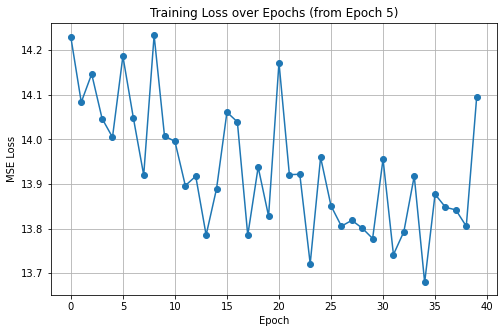

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(losses[4:], marker='o')  # 只画第5轮以后
plt.title("Training Loss over Epochs (from Epoch 5)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

In [14]:
# 第6块：测试阶段，计算正常和异常样本的重建误差
def compute_reconstruction_errors(model, csv_path):
    dataset = HGCalDataset(csv_path)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()
    errors = []

    with torch.no_grad():
        for sample in loader:
            output = model(sample)
            mse = nn.functional.mse_loss(output, sample).item()
            errors.append(mse)
    return np.array(errors)


# 加载测试数据
test_normal_csv = "hgcal_rdf_test_normal.csv"
test_anomaly_csv = "hgcal_rdf_test_anomaly.csv"

normal_errors = compute_reconstruction_errors(model, test_normal_csv)
anomaly_errors = compute_reconstruction_errors(model, test_anomaly_csv)


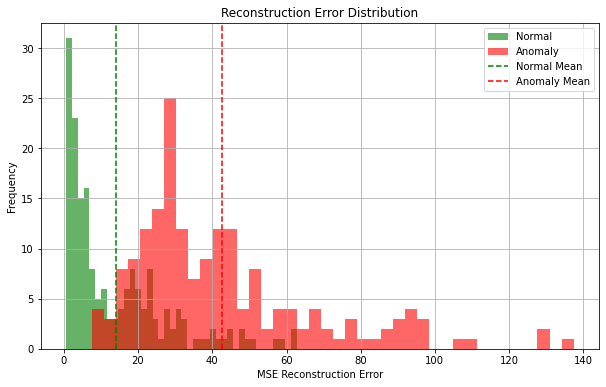

In [15]:
# 第7块：可视化误差分布（用于区分正常与异常）
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=40, alpha=0.6, label='Normal', color='green')
plt.hist(anomaly_errors, bins=40, alpha=0.6, label='Anomaly', color='red')
plt.axvline(np.mean(normal_errors), color='green', linestyle='--', label='Normal Mean')
plt.axvline(np.mean(anomaly_errors), color='red', linestyle='--', label='Anomaly Mean')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

AUC: 0.8772
              precision    recall  f1-score   support

      Normal       0.99      0.50      0.66       180
     Anomaly       0.67      0.99      0.80       180

    accuracy                           0.75       360
   macro avg       0.83      0.75      0.73       360
weighted avg       0.83      0.75      0.73       360



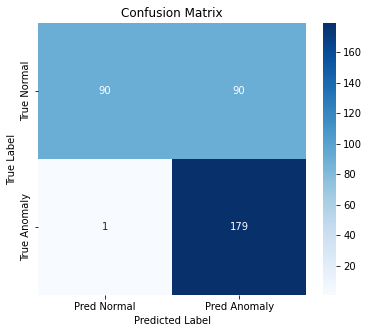

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import seaborn as sns

# 拼接正常与异常的误差
all_errors = np.concatenate([normal_errors, anomaly_errors])
# 构造对应标签（0: 正常，1: 异常）
all_labels = np.array([0]*len(normal_errors) + [1]*len(anomaly_errors))

# 计算 AUC
auc = roc_auc_score(all_labels, all_errors)
print(f"AUC: {auc:.4f}")

# 自动根据误差中位数生成阈值，也可以自己手动设定
threshold = np.median(normal_errors)

# 根据阈值进行预测
predicted_labels = (all_errors > threshold).astype(int)

# 打印分类报告
report = classification_report(all_labels, predicted_labels, target_names=['Normal', 'Anomaly'])
print(report)

# 可视化混淆矩阵
cm = confusion_matrix(all_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred Normal', 'Pred Anomaly'], yticklabels=['True Normal', 'True Anomaly'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
